# Diabetes Prediction with Logistic Regression

In diesem Projekt werden die logistische Regression und ein Klassifizierungsprozess unter Berücksichtigung von Erfolgsmetriken und Modelvalidierungsmethoden analysiert. Zudem erfolgt eine Evaluation einer End-to-End-Maschinenlernklassifizierungsaufgabe anhand eines realen Datensatzes und eines realen Problems. Die Diabetesvorhersage wird mittels logistischer Regression durchgeführt, um ein entsprechendes Vorhersagemodell zu erstellen. Das Ziel besteht darin, die Einflussfaktoren auf das Auftreten von Diabetes zu untersuchen und ein Modell zu entwickeln, das basierend auf den Informationen einer neuen Person prognostiziert, ob diese an Diabetes erkranken wird oder nicht.

Die Schritte, die in diesem Projekt unternommen werden, sind:

1. Exploratory Data Analysis
2. Data Preprocessing
3. Model & Prediction
4. Model Evaluation
5. Model Validation: Holdout
6. Model Validation: 10-Fold Cross Validation
7. Prediction for A New Observation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (C:\Users\Naime Diler\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate

# pip install scikit-plot
from scikitplot.metrics import plot_roc_curve

Zur Identifizierung von Ausreißerwerten in einer Variablen ist zunächst die Berechnung eines Schwellenwerts erforderlich.

In [3]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

Nach der Berechnung dieser Schwellenwerte wird überprüft, ob in einer Variablen Ausreißerwerte vorhanden sind.

In [4]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

Die Verwendung der berechneten Schwellenwerte ermöglicht die Identifizierung von Ausreißerwerten in einer Variablen und deren potenzielle Ersetzung durch dieselben
Schwellenwerte.

In [5]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

Hinweis: 

Bei der Berechnung der Ausreißerschwellenwerte mit der IQR-Methode, auch bekannt als Boxplot-Methode, werden üblicherweise die 25. und 75. Perzentile verwendet. Allerdings wird oft die Verwendung der 5. und 95. Perzentile bevorzugt. Dies geschieht, um Mehrfachwirkungen nicht zu vernachlässigen und nurdie extremsten Ausreißer anzusprechen.

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# Exploratory Data Analysis

In [7]:
df = pd.read_csv(r"C:\Users\Naime Diler\Desktop\PycharmProjects\datasets/diabetes.csv")

In [8]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [9]:
df.shape

(768, 9)

### Analyse der Zielvariable

In [10]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

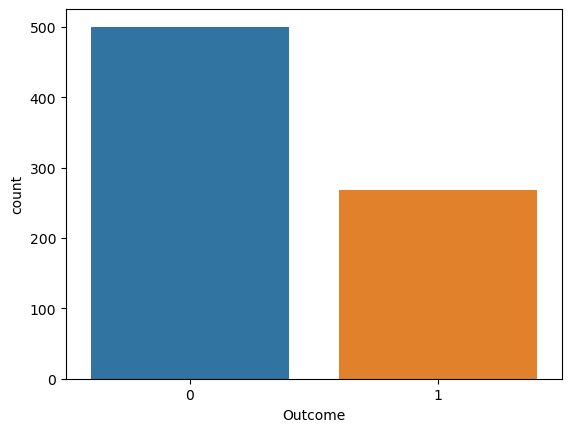

In [11]:
sns.countplot(x="Outcome", data=df)
plt.show(block=True)

Um die Anteile der Klassen im Datensatz in Prozent zu erhalten:

In [12]:
100 * df["Outcome"].value_counts() / len(df)

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

### Merkmalsanalyse (Features)

Eine übliche Herangehensweise zur Analyse der unabhängigen Variablen ist die Verwendung der describe() -Funktion. Diese Funktion bietet eine Zusammenfassung der
numerischen Variablen und liefert statistische Kennzahlen zu ihrem Zustand.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


Hier liegen einige ungewöhnliche Zustände vor, die während des Preprocessings kurz bewertet werden.

Visualisierung von numerischen Variablen:

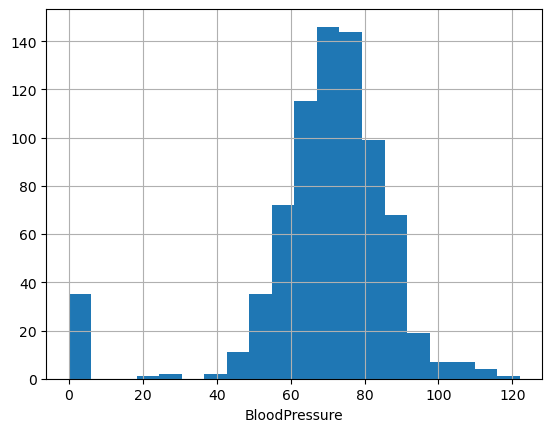

In [14]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show() 

für alle:

In [15]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)  
    
# Die Einstellung block=True wird verwendet, um sicherzustellen, dass aufeinanderfolgende Grafiken nicht überlagert werden, wenn sie
# angezeigt werden.

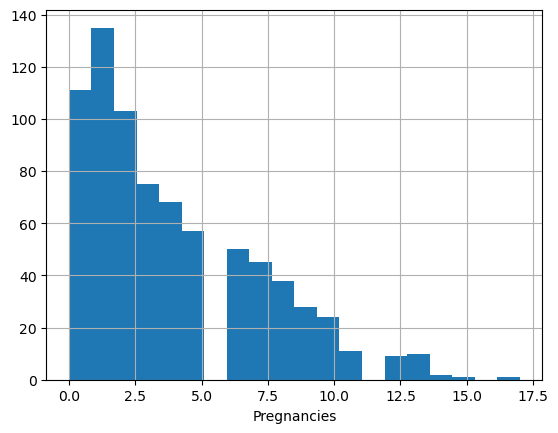

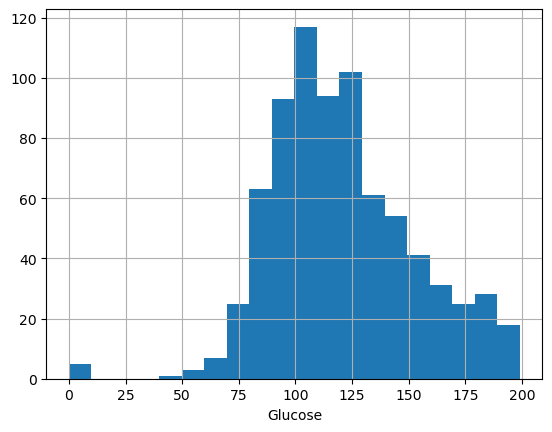

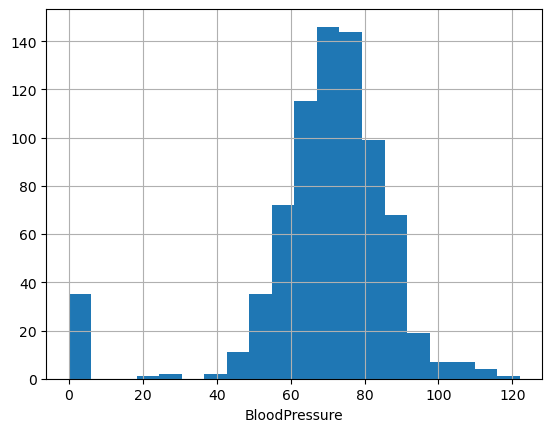

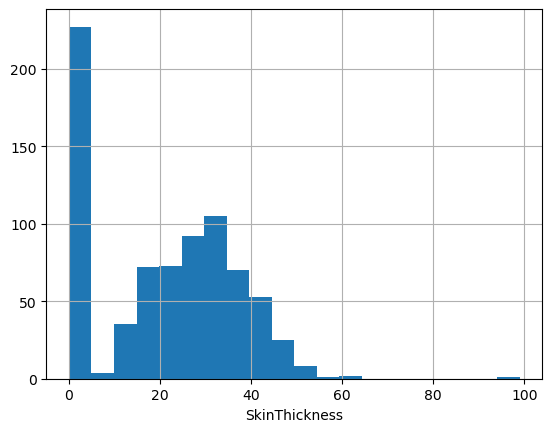

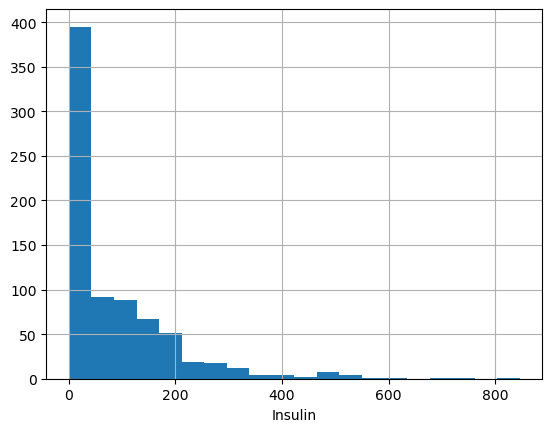

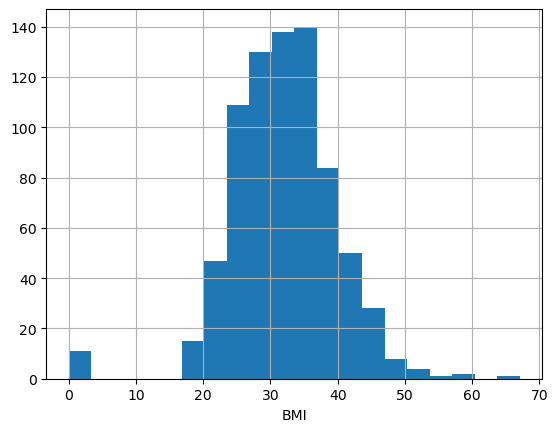

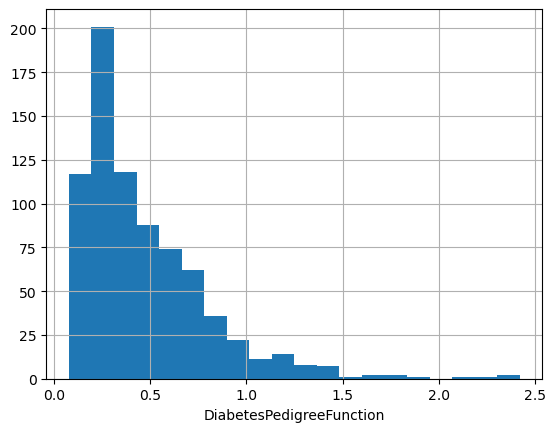

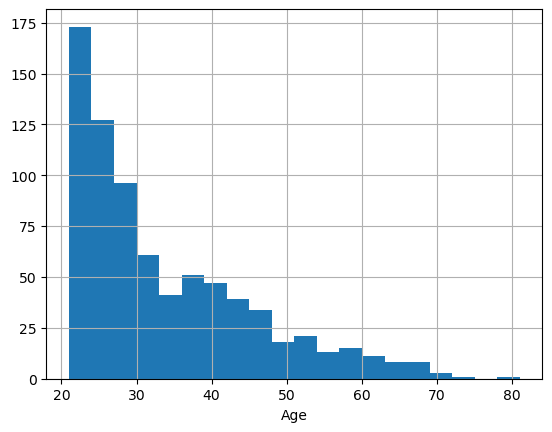

In [16]:
cols = [col for col in df.columns if "Outcome" not in col]

for col in cols:
   plot_numerical_col(df, col)

Hinweis: 
Da im vorliegenden Datensatz ausschließlich numerische Variablen vorhanden sind, ohne kategoriale, kann die Funktion plot_numerical_col ohne Probleme genutzt
werden, ohne zuvor die numerischen und kategorialen Variablen trennen zu müssen.

Zusammenfassung: 

Sowohl die Zielvariable als auch die Merkmale, also die unabhängigen Variablen, wurden getrennt untersucht. Die Analyse ist nun abgeschlossen.

### Target vs Features

Um ein Verständnis dafür zu erlangen, wie sich das Target auf unabhängige Variablen auswirkt:

In [17]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [18]:
# Zusammenfassung des Targets mit numerischen Variablen:

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in cols: # cols wurde oben definiert!
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




Fazit:
    
Die durchschnittliche Altersspanne der Personen mit Diabetes beträgt 37 Jahre, während sie bei Personen ohne Diabetes niedriger ist.
Bei der Variable BMI, die den Body-Mass-Index ausdrückt, ist der Durchschnitt bei Personen mit Diabetes höher als bei denen ohne Diabetes.
Der Durchschnitt des Insulins bei Personen mit Diabetes ist im Vergleich zu denen ohne Diabetes höher.
Es ist erkennbar, dass zwischen den unabhängigen und abhängigen Variablen eine Diskrepanz besteht. Nach der Analyse mittels groupby() und der Betrachtung der
Durchschnittswerte können einige Ideen abgeleitet werden. Auf dieser Grundlage können verschiedene Maßnahmen ergriffen werden, wenn zur Modellierung übergegangen
wird.

# Data Pre-processing

### Missings values

In [19]:
df.isnull().sum()

# Es gibt keine fehlenden Werte. Describe durchführen:

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


Bei Blutdruck kann der Mindestwert nicht 0 sein, da dies darauf hindeutet, dass das Herz der betreffenden Person nicht schlägt. Ebenso dürfen bei BMI oder Insulin
keine 0-Werte auftreten. Somit scheinen die fehlenden Werte in diesem Datensatz durch Nullen ersetzt worden zu sein, möglicherweise aufgrund der Datenquelle. Es
wurde festgestellt, dass keine fehlenden Werte vorhanden sind, jedoch sind tatsächlich fehlende Werte vorhanden, die einfach durch Nullen ersetzt wurden. In diesem
Projekt liegt der Fokus nicht auf der Date Preprocessing, daher wird der Prozess fortgesetzt, als ob keine fehlenden Werte vorhanden wären. Letztendlich hat die
Datenquelle, von der dieser Datensatz stammt, diese Vorgehensweise angewendet. Es könnte jedoch bevorzugt werden, diese Nullwerte durch NaN-Werte zu ersetzen und
entsprechend zu behandeln, insbesondere wenn das Fehlen von Werten ein Problem darstellt.

### Outliers

In [21]:
for col in cols:
    print(col, check_outlier(df, col))
    
# Es ist nur ein Ausreißerwert in der Insulinvariable vorhanden.

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [22]:
# replace: Unterdrückungsmethode:

replace_with_thresholds(df, "Insulin")

C:\Users\Naime Diler\AppData\Local\Temp\ipykernel_14576\130684917.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-439.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [23]:
# Um die Warnung zu vermeiden:

import warnings
warnings.simplefilter(action="ignore")

replace_with_thresholds(df, "Insulin")

In [24]:
for col in cols:
    print(col, check_outlier(df, col))
    

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


Ein weiterer Schritt in der Datenverarbeitung besteht darin, die Variablen zu skalieren, um sie zu standardisieren. 

Hinweis:


In linearen und distanzbasierten Methoden sowie bei Verfahren, die den Gradientenabstieg nutzen, ist die Standardisierung üblicherweise von großer Bedeutung und erfordert besondere Aufmerksamkeit. Die Standardisierung ist aus zwei Gründen wichtig: Erstens muss sichergestellt werden, dass die Modelle gleichermaßen auf die Variablen reagieren. Zum Beispiel darf kein inhärenter Vorteil größerer Werte gegenüber kleineren angenommen werden, weshalb eine Standardisierung erforderlich ist. Zweitens wird die Skalierung der Variablen bevorzugt, um eine schnellere und genauere Arbeit der Parameterschätzmethoden zu ermöglichen.

In [25]:
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

Die 'cols' repräsentieren die unabhängigen Variablen. Der RobustScaler subtrahiert den Median aller Beobachtungseinheiten und teilt durch den Interquartilsabstand (Interquartile Range, IQR). Im Vergleich zum StandardScaler ist der RobustScaler robuster gegenüber Ausreißern. Obwohl eine leichte Bereinigung der Daten erfolgte, wurde der RobustScaler bevorzugt, da er wie der StandardScaler verwendet werden kann. Alternativ könnte auch der MinMaxScaler verwendet werden, um die Werte zwischen 0 und 1 zu bringen. Die Entscheidung für den RobustScaler wurde aufgrund seiner Robustheit gegenüber Ausreißern getroffen. Daher wurden alle Merkmale des Datensatzes durch diesen Scaler transformiert.

In [26]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


# Model & Prediction

Erinnerung:
    
Das Ziel besteht darin, mittels der logistischen Regressionsmethode die Beziehung zwischen unabhängigen und abhängigen Variablen zu modellieren. Dabei ging es darum, basierend auf den Merkmalen von Personen Vorhersagen über das Vorhandensein von Diabetes zu treffen.

In [27]:
y = df["Outcome"]

X = df.drop(["Outcome"], axis=1)

In [28]:
log_model = LogisticRegression().fit(X, y)

Frage: Wie erhält man den Intercept dieses Modells?

Der Intercept kann auch als Bias oder Beta-Koeffizient bezeichnet werden. Es handelt sich jedoch nicht genau um einen Koeffizienten, da keine Abhängigkeit von
einer Variablen besteht.

Antwort:

In [29]:
log_model.intercept_

array([-1.23439588])

Für die Betrachtung der Koeffizienten der anderen Variablen, beziehungsweise ihrer Gewichte, kann der Ausdruck coef_ verwendet werden. Hierbei handelt es sich um
die Gewichte der unabhängigen Variablen.

In [30]:
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

Wie lautet die Gleichung dieses Modells?

y_pred = b + w1*x1 + w2*x2 + ... + wn*xn 

In dieser Formel sind die Gewichte und die Konstante, dargestellt als Koeffizienten und Interzept, enthalten.

Die Prognose wird nun unter Verwendung dieses Modells durchgeführt.

In [31]:
y_pred = log_model.predict(X)

In [32]:
# Zur Veranschaulichung werden die ersten zehn geschätzten Werte betrachtet.

y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [33]:
# y repräsentierte die tatsächlichen Werte:

y[0:10]

# Es zeigt sich, dass gelegentlich richtige Vorhersagen getroffen werden, während dies manchmal nicht der Fall ist.

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

Ein Modell wurde auf dem gesamten Datensatz trainiert und befindet sich noch im Evaluierungsprozess. Die Modellbildung ist abgeschlossen. Vor dem Hintergrund der vorhandenen Vorhersagen und realen Werte wird nun die Wirksamkeit der Vorhersagen überprüft. Im nächsten Schritt erfolgt die Bewertung der Modellleistung.

# Model Evaluation 

Die verfügbaren Daten bestehen aus den realen Werten (y) und den prognostizierten Werten (y_pred), welche die Grundlage für eine objektive Leistungsbewertung
bilden. Mithilfe der Konfusionsmatrix können Kennzahlen wie Präzision, Rückruf (Recall), F1-Score und Genauigkeit abgeleitet werden, welche für die Bewertung
dieser Leistung entscheidend sind.

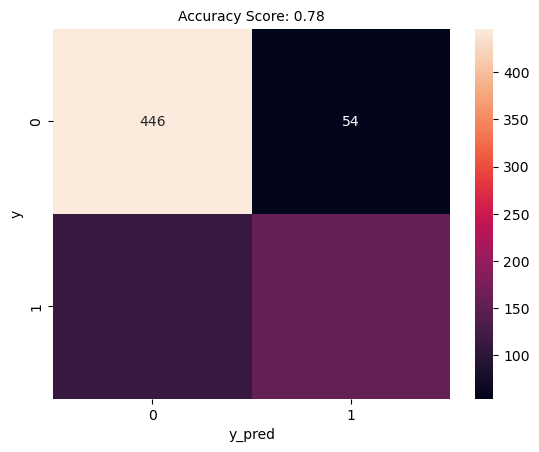

In [34]:
# Visualisierung der Konfusionsmatrix:

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show(block=True)
    
    
plot_confusion_matrix(y, y_pred)

Hinweis:
    
 - "Accuracy" oder "Genauigkeit" ist die Rate der korrekten Klassifizierung in einem Klassifizierungsmodell.
 - Die precision ist ein Maß dafür, wie genau ein Modell positive Vorhersagen trifft, d.h. wie viele der als positiv vorhergesagten Fälle tatsächlich positiv sind.
 - Der recall ist ein Maß dafür, wie viele der tatsächlich positiven Fälle vom Modell korrekt identifiziert wurden.
 - Der F1-Score wird aus precision und recall berechnet und verwendet die harmonische Mittel, um ein ausgewogenes Maß für die Modellleistung zu erhalten.

Rechnung:
Precision: 156 / (156+54)
Recall: 156 / (156 + 112)
Accuracy: (156+446) / alle Beobachtungen (768)

In [35]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



Die ROC-AUC (Receiver Operating Characteristic - Area Under Curve) ist eine Metrik zur Bewertung der Leistung eines Klassifizierungsmodells, indem sie den Bereich unter der ROC-Kurve misst. Die ROC-Kurve zeigt die Leistung des Modells bei verschiedenen Klassifizierungsschwellenwerten, während die AUC angibt, wie gut das Modell in der Lage ist, zwischen den Klassen zu unterscheiden, unabhängig von der gewählten Schwellenwert.

Die Berechnung dieser Metrik erfordert geschätzte Wahrscheinlichkeitswerte für das Eintreten der Klasse 1 der abhängigen Variablen. Dies ist notwendig, da sich die Schwellenwerte möglicherweise ändern. Beispielsweise: Welche Erfolgsrate haben wir bei einer Klassifizierungsschwelle von 0,4? Und bei 0,5? Oder bei 0,7? Die Berechnung basiert auf diesen potenziellen Schwellenwerten, ähnlich wie bei der ROC-Kurve und der AUC. Daher sind die Wahrscheinlichkeiten für das Eintreten der Klasse 1 entscheidend. Nach Erhalt dieser Werte kann der AUC-Score mithilfe der Methode roc_auc_score ermittelt werden. Zu beachten ist, dass das Modell sowohl mit Trainings- als auch mit Testdaten validiert wurde, was zusätzliche Überprüfungen erfordert. Validierungsmethoden für Modelle werden im nächsten Abschnitt erörtert.

In [36]:
# ROC AUC   
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

# 0,83939 bedeutet, dass eine Vorhersagegenauigkeit von etwa 84 % besteht.

0.8393955223880598

# Model Validation: Holdout

"Hold-out": Man teilte den Datensatz in zwei Teile auf, wobei ein Teil zum Trainieren des Modells und der andere Teil zum Testen des Modells verwendet wird.

In [37]:
# X repräsentiert unabhängige Variablen, während y die abhängige Variable darstellt.

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

In [38]:
# Modellbildung auf dem Trainingsdatensatz:

log_model = LogisticRegression().fit(X_train, y_train)

In [39]:
# Testdatensatz dem Modell vorlegen:

# Vorhersagen sollen anhand unbenutzter Daten getroffen werden. Diese enthalten unabhängige Variablen wie die Anzahl der Schwangerschaften und den BMI-Wert. Das Zie
# ist es, zu bestimmen, ob die Personen an Diabetes leiden oder nicht. Anschließend werden diese Vorhersagen mit den tatsächlichen Werten verglichen.

y_pred = log_model.predict(X_test) # Die geschätzten Werte sind angekommen. Da die tatsächlichen Werte ebenfalls vorliegen, werden beide miteinander verglichen.

In [40]:
# Für die AUC-Berechnung werden nun neben den geschätzten Werten auch die Wahrscheinlichkeiten für die Zugehörigkeit zur Klasse 1 erfasst. Die unabhängigen
# Variablenwerte wurden bereits übermittelt, und im Gegenzug werden die Wahrscheinlichkeitswerte erwartet.

y_prob = log_model.predict_proba(X_test)[:, 1] # Die Syntax "[:,1]" wird verwendet, um nur die Wahrscheinlichkeiten für das Eintreten der Klasse 1 aus dem
# Ausgabearray von "predict_proba()" zu extrahieren.

In [41]:
# Nun erfolgt die Bewertung der Leistung. Zuvor wurde die Methode "Classification Report" verwendet. Diese wird nun erneut verwendet. Dabei sind y_pred die gerade
# geschätzten Werte und y_test die echten y-Werte im Testdatensatz. Es handelt sich dabei um den Teil des Datensatzes, den das Modell nicht gesehen hat.

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



Hier sind die vorherigen Werte:

Accuracy: 0.78
Precision: 0.74
Recall: 0.58
F1-score: 0.65

Diese Metriken beziehen sich auf die Klasse 1:

Accuracy: 0.77
Precision: 0.79
Recall: 0.53
F1-score: 0.63

In [42]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

InvalidParameterError: The 'pos_label' parameter of roc_curve must be an instance of 'float', an instance of 'str', an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int' or None. Got LogisticRegression() instead.

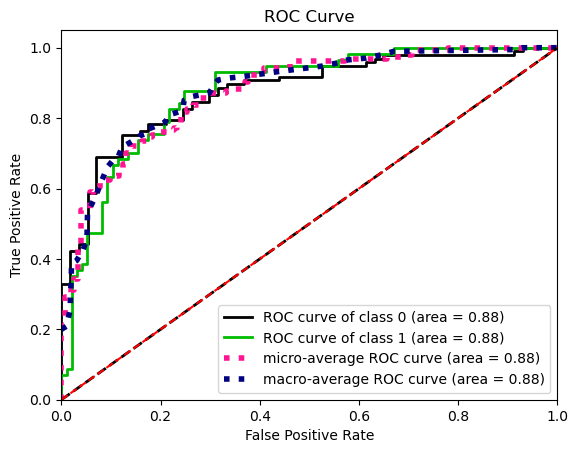

In [43]:
from scikitplot.metrics import plot_roc_curve

# Vorhersagen des Modells für Testdaten
y_probas = log_model.predict_proba(X_test)

# Plot der ROC-Kurve
plot_roc_curve(y_test, y_probas)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()


In [44]:
roc_auc_score(y_test, y_prob)

0.8755652016639537

Der zuvor berechnete AUC-Score lag bei etwa 0,84. Hier beträgt er 0,88. Der AUC-Score ist gestiegen, während der recall abgenommen hat. Eine Änderung des
random_state-Parameters wird sich auf die Leistung des Modells auswirken. Eine erneute Überprüfung der Testfehler und des Klassifizierungsberichts ist
erforderlich, um den Einfluss der Änderung des random_state zu bewerten:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=987)
log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        92
           1       0.80      0.56      0.66        62

    accuracy                           0.77       154
   macro avg       0.77      0.73      0.74       154
weighted avg       0.77      0.77      0.76       154



Während der Evaluierung haben sich bestimmte Kennzahlen verändert. Die Genauigkeit (Accuracy) blieb konstant, jedoch zeigten die Precision, der Recall-Wert und der F1-Score Veränderungen. Obwohl das Modell validiert wurde, ist unklar, welche Daten für die Validierung verwendet wurden. Die Verwendung verschiedener Datensätze durch Änderung der Zahl bei "random_state" führt zu unterschiedlichen Ergebnissen. Die Anwendung der 10-fachen Kreuzvalidierungsmethode ermöglicht es, potenzielle Unterschiede zu berücksichtigen und das genannte Problem zu lösen.

# Model Validation: 10-Fold Cross Validation

Die k-Fache Kreuzvalidierung ist eine Methode zur Bewertung der Leistung von Machine-Learning-Modellen. Bei der k-Fachen Kreuzvalidierung wird der Datensatz in k
Teile aufgeteilt. Das Modell wird dann k-mal trainiert und getestet, wobei jedes Mal ein anderer Teil für Tests verwendet wird und die restlichen Teile für das
Training dienen. Durchschnittlich werden die Testergebnisse aller Durchläufe verwendet, um die Leistung des Modells zu bewerten und mögliche Variationen zu
berücksichtigen. Die Methode hilft, die Robustheit und Zuverlässigkeit des Modells zu prüfen und zu verbessern, indem sie verschiedene Szenarien und
Datenkombinationen berücksichtigt.

In [46]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

Zwei Ansätze zur Evaluierung der Leistung von Machine-Learning-Modellen: Wenn der Datensatz groß ist, wird empfohlen, ihn in Trainings- und Testdaten aufzuteilen,
eine 10-fache Kreuzvalidierung auf dem Trainingsdatensatz durchzuführen und dann die Leistung des Modells anhand des Testdatensatzes zu überprüfen. Wenn der
Datensatz jedoch klein ist, kann der gesamte Datensatz für das Training und die Kreuzvalidierung verwendet werden. Beide Ansätze dienen dazu, die Modellleistung zu
bewerten, wobei die Wahl des Ansatzes von der Größe des Datensatzes abhängt.

In diesem Fall wird der gesamte Datensatz für das Training des Modells genutzt. Das bedeutet, dass das Modell auf dem gesamten Datensatz trainiert wird, ohne eine
Aufteilung in Trainings- und Testdaten vorzunehmen.

In [47]:
log_model = LogisticRegression().fit(X, y)

Der Prozess der Kreuzvalidierung (Cross Validation) zur Bewertung eines Machine-Learning-Modells verläuft wie folgt: die Methode cross_validate wird verwendet, um
das Modell zu trainieren und zu testen. Die cross_validate-Methode erfordert die Angabe eines Modells, der unabhängigen Variablen sowie die Anzahl der Folds für
die Kreuzvalidierung. Sie ermöglicht es auch, verschiedene Erfolgsmetriken wie accuracy, precision, recall, F1-Score und AUC-Wert zu berechnen.

In [48]:
cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

Analyse der Kreuzvalidierungsergebnisse: 
    
Es wurden fünf Testläufe durchgeführt, wobei jeweils vier Teile für das Training und einer für den Test verwendet wurden. Nach jedem Testlauf wurden die
Testergebnisse, insbesondere die Testgenauigkeiten, überprüft. Durch die Berechnung des Durchschnitts der Testergebnisse erhält man eine Metrik, die die Leistung
des Modells über alle Testläufe hinweg zusammenfasst:

In [49]:
cv_results['test_accuracy'].mean()
# Accuracy: 0.7721

# Die durchschnittliche Genauigkeit des Modells beträgt demnach über alle fünf Testläufe hinweg 77,21%. 

0.7721925133689839

Alle anderen Metriken sollten ebenfalls berücksichtigt und die Ergebnisse anschließend ausgewertet werden:

In [50]:
cv_results['test_precision'].mean()

0.7192472060223519

In [51]:
cv_results['test_recall'].mean()

0.5747030048916841

In [52]:
cv_results['test_f1'].mean()

0.6371421090986309

In [53]:
cv_results['test_roc_auc'].mean()

0.8327295597484277

Vergleich der Ergebnisse von den verschiedenen Validierungsmethoden:

Base:

- Accuracy: 0.78
- Precision: 0.74
- Recall: 0.58
- F1-score: 0.65

Hold out:

- Accuracy: 0.77
- Precision: 0.79
- Recall: 0.53
- F1-score: 0.63


Cross Validation:

- Accuracy: 0.7721
- Precision: 0.7192
- Recall: 0.5747
- F1-score: 0.6371
- AUC: 0.8327 

Die Genauigkeit begann bei 78 %, sank dann auf 77 % und endete schließlich bei 77 % (aus der Kreuzvalidierung). Dies deutet darauf hin, dass mit größerer Sicherheit eine Klassifizierungsgenauigkeit von 77 % erreicht werden kann. Die Genauigkeitsrate beträgt 0,7721.

Die Precision liegt bei 0,7192, während frühere Ergebnisse Werte von 74 und 79 zeigten. Hierbei ist anzumerken, dass unabhängig von dem betrachteten Wert Fragen offen bleiben würden. Durch die zehnfache Kreuzvalidierung bietet der aktuelle Precisionwert einen klareren Indikator für die Leistung des Modells bei der Vorhersage der Klasse 1. Der Recall-Wert beträgt 0,5747 (aus der Kreuzvalidierung), während frühere Ergebnisse 0,53 und 0,58 zeigten. Dies bedeutet, dass die Fähigkeit, tatsächliche 1en vorherzusagen, bei etwa 0,57 liegt. Der F1-Score, als harmonisches Mittel von Precision und Recall, beträgt 0,6371, während andere Werte bei 0,63 und 0,65 lagen, was relativ nahe beieinander liegt.

Zusammenfassend wurde der Modellierungsprozess abgeschlossen, und es liegen nun Antworten auf die Frage nach der Leistung des Modells aus verschiedenen Blickwinkeln vor. Während bei einem perfekt ausgeglichenen Datensatz nur die Genauigkeit betrachtet werden könnte, berücksichtigen wir bei diesem Datensatz auch andere Faktoren wie den F1-Score. Obwohl der F1-Score mit 63 % (aus der Kreuzvalidierung) nicht als sehr gut bezeichnet werden kann, ist er auch nicht als sehr schlecht einzustufen. Der AUC-Wert von 83 % ist jedoch ziemlich gut.

Zusammenfassend ist festzustellen, dass dieses Modell bemerkenswert ist. Es wurden keine umfangreichen Variablentransformationen oder detaillierten Datenbereinigungen durchgeführt, dennoch wurde ein zufriedenstellendes Ergebnis erzielt.

# Prediction for A New Observation

Nachdem das Ziel, ein Modell zur Vorhersage von Diabetes zu entwickeln, festgelegt wurde, ist es nun an der Zeit, die Wirksamkeit dieses Modells zu überprüfen. Durch die Klassifizierung von Personen basierend auf ihren Merkmalen können wir feststellen, ob sie an Diabetes erkrankt sind oder nicht.

In [54]:
random_user = X.sample(1, random_state=45)

log_model.predict(random_user)

array([1], dtype=int64)